Matteo Picciolini

# Esercitazione 12 - Esercizi 12.2 e 12.3

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D
from PIL import Image
import os

seed = 0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

2023-06-15 09:55:34.153825: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 09:55:34.210271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 09:55:34.212463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 09:55:35.218199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end.

### Soluzione

Finora ho considerato ogni campione di dati MNIST come un vettore 1D di lunghezza $(28x28)$. D'altra parte, in ogni cifra scritta a mano ci sono correlazioni spaziali locali tra i pixel, ma anche invarianza traslazionale, di cui si vorrebbe approfittare per migliorare l'accuratezza del modello. A tal fine, prima di tutto è necessario ridimensionare i dati di input di addestramento e di test come segue:

In [2]:
img_rows, img_cols = 28, 28 # input image dimensions (pixels) 
num_classes = 10 # output: 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape) # l'input
print('Y_train shape:', Y_train.shape) # label, ovvero gli output
print('X_test shape:', X_test.shape) # l'input
print('Y_test shape:', Y_test.shape) # label, ovvero gli output


if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('Before to_categorical: ')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

# cast floats to single precision, and rescale to interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('After to_categorical: ')
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)
Before to_categorical: 
X_train shape:  (60000, 28, 28, 1)
Y_train shape:  (60000,)
Train samples:  60000
Test samples:  10000
After to_categorical: 
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)


A questo punto, lavorando sul codice dell'esercizio precedente, provo a migliorare le performance della rete, modificandone l'architettura attraverso l'utilizzo dei *convolutional layers*:
- Il layer `Conv2D` è un layer convoluzionale che, collegandosi al layer precedente, restituisce un'output con una forma 2D.
- Il layer `MaxPooling2D` riduce l'immagine di input prendendo il valore massimo di un pixel all'interno di una finestra di dimensioni fissate.
- Il layer `Dropout` disattiva alcuni neuroni durante l'addestramento per rendere più difficile l'apprendimento e rendere il modello più robusto.
- Il layer `Flatten` trasforma l'input da una forma 2D a una forma monodimensionale, consentendo l'utilizzo di altri layer di tipo Dense.
- Infine, viene utilizzato il layer `softmax` per fornire output più netti possibile.

In [3]:
def create_CDNN():
    model = Sequential()
    #----------create layers-------------                                                    
    model.add(Conv2D(10, kernel_size = (5, 5),
                     activation = 'relu',
                     input_shape = input_shape))
    model.add(Conv2D(64, kernel_size = (5, 5), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size = (4, 4)))
    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def compile_model():
    # create the model
    model = create_CDNN()
    # compile the model
    model.compile(loss = keras.losses.categorical_crossentropy,
                  optimizer = 'nadam',
                  metrics = ['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [4]:
my_batch_size = 32
epochs = 8

model_CDNN = compile_model()


history = model_CDNN.fit(X_train, Y_train,
                        batch_size = my_batch_size,
                        epochs = epochs,
                        verbose = 1,
                        validation_data = (X_test, Y_test)
                        )

2023-06-15 09:55:37.481235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/8


2023-06-15 09:55:37.697915: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 51s 26ms/step - loss: 0.3037 - acc: 0.9062 - val_loss: 0.1663 - val_acc: 0.9733
Epoch 2/8
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1027 - acc: 0.9704 - val_loss: 0.1077 - val_acc: 0.9798
Epoch 3/8
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0754 - acc: 0.9774 - val_loss: 0.0894 - val_acc: 0.9806
Epoch 4/8
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0586 - acc: 0.9823 - val_loss: 0.0642 - val_acc: 0.9852
Epoch 5/8
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0493 - acc: 0.9855 - val_loss: 0.0703 - val_acc: 0.9842
Epoch 6/8
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0417 - acc: 0.9877 - val_loss: 0.0553 - val_acc: 0.9860
Epoch 7/8
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0382 - acc: 0.9883 - val_loss: 0.0437 - val_acc: 0.9874
Epoch 8/8
1875/1875 [==============================] - 42s 23ms/s

313/313 [==============================] - 2s 5ms/step - loss: 0.0406 - acc: 0.9886

Test loss: 0.04062013700604439
Test accuracy: 0.9886000156402588


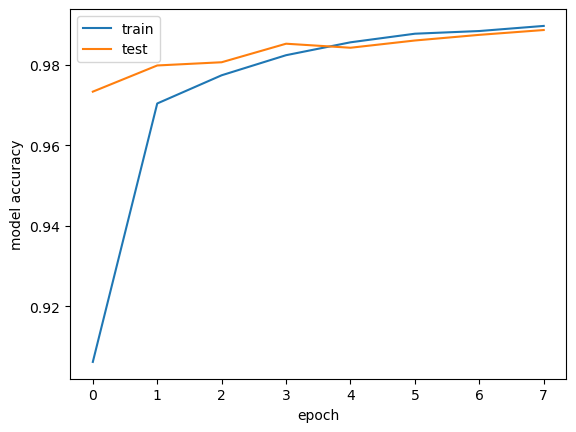

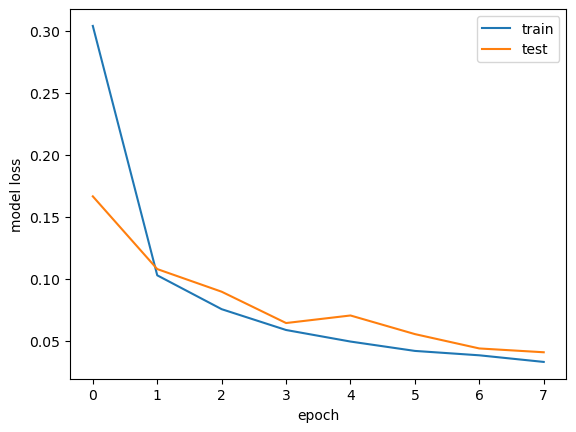

In [5]:
# evaluate model
score = model_CDNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

#### Commenti
Rispetto all'esercizio precedente la *loss* e l'*accuracy* sono certametne migliorate, soprattutto confrontandole a parità di numero di epoche. La bontà del modello è, però, garantita a spese di un tempo computazionale per epoca decisamente maggiore, dell'ordine di $\sim 5$ volte il tempo di allenamento di un'epoca dell'esercizio $12.1$.

Una volta allenata la rete e fissati i parametri, quindi, si ottiene dopo $7$ epoche un valore di *loss* per il test pari $0.04$ e un valore di *accuracy* del $98,9%$. Rispetto all'esercizio precedente ho utilizzato un ottimizzatore diverso: `nadam`, che permette di ottenere risultati molto migliori rispetto allo stesso modello con l'ottimizzatore `adagrad`, soprattutto in termini di *loss*. Inoltre, con `nadam` ho potuto fermarmi alla settima epoca, perchè i risultati erano già ottimi, mentre con `adagrad` sono dovuto andare oltre la $10$ per ottenere comuqnue risultati peggiori di questi che sono esposti ora.

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

#### Soluzione
Ho usato l'applicazione `gimp` per generare alcune cifre per testare personalmente la rete. Riporto di seguito i risultati.

1/1 [==============================] - 0s 18ms/step


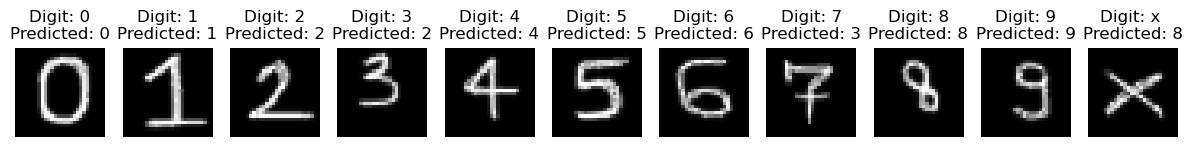

In [8]:
digit_filenames = [ "../../Data/12.3_zero.png",
                    "../../Data/12.3_one.png",
                    "../../Data/12.3_two.png",
                    "../../Data/12.3_three.png",
                    "../../Data/12.3_four.png",
                    "../../Data/12.3_five.png",
                    "../../Data/12.3_six.png",
                    "../../Data/12.3_seven.png",
                    "../../Data/12.3_eight.png",
                    "../../Data/12.3_nine.png",
                    "../../Data/12.3_x.png"]
data = []

for digit_filename in digit_filenames:
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load()
    img = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            img[i,j] = pix[j, i] / 255
    data.append(img)


predictions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(0, 11):
    data[i] = data[i].reshape(1, xdim, ydim, 1)
    predictions[i] = model_CDNN.predict(data[i])
    data[i] = data[i].reshape(xdim,ydim)

plt.figure(figsize = (15, 4))
for i in range(11):    
    ax = plt.subplot(1, 11, i + 1)    
    plt.imshow(data[i], cmap = 'gray')
    if i != 10:
        plt.title("Digit: "+ str(i) + "\nPredicted: {}".format(np.argmax(predictions[i])))
    else:
        plt.title("Digit: x \nPredicted: {}".format(np.argmax(predictions[i])))
    plt.axis('off') 


#### Commenti
I risultati mostrano un'ottimo accordo. L'unica cifra che viene predetta in maniera errata è la cifra $7$, che ho volutamente scrivere in modo non usuale, proprio per testare l'efficacia della rete nel riconoscere anche cifre con tratti non usuali. Il limite della rete è, evidentemente, proprio questo.
Ho provato anche a scrivere alcune cifre leggermente ruotate (come l'"8") o leggeremtne traslate (come il "3"). La rete è stata, però in grado di riconoscere ugualmente la cifra. Trovo interessante che lo stesso modello con l'ottimizzatore `adagrad` restituisse predizioni di queste cifre scritte da me sbagliate, nonostante l'*accuray* coi dati di *test* fosse di circa il $95%$.
Ho voluto anche "ingannare" la rete provando a scrivere un simbolo che non corrisponde a nessuna cifra. Il simbolo che ho utilizzato è "x", e trovo curioso che la predizione della rete sia proprio "8", perchè è l'unica cifra con un pattern simile (il centro della cifra "8" è simile a una "x"). Questo significa che la rete a riconoscituo quel pattern e ha assunto che si trattasse di un "8".